In [1]:
%pylab inline
import pymc3 as pm

Populating the interactive namespace from numpy and matplotlib


/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from scipy.linalg import inv
from scipy.special import expit # inverse logit

#######################################################################
np.random.seed(265)#np.random.randint(1, 2**16))
#set the true parameter values of the parameters
true_alpha = np.array([1.35, 1.75])
true_beta = np.array([-1.85, 2.5])
len_alpha = len(true_alpha)
len_beta = len(true_beta)
#n = number of sites visited, K = number of visits per site
n = 100
K_ = 20
K = np.random.randint(2,K_, n)
#K = np.repeat(K_, n)
#=========================generate x and W matrices=========================
#generate an array with n*(r-1) elements as uniform variates on (-2, 2)
x1 = np.random.uniform(-2.0, 2.0, size = n*(len_beta-1))
x = (x1 - np.mean(x1)) / np.std(x1) #standardize the generated results
#X is 2D array with dimensions (n, r)
X = np.ones((n, len_beta), dtype=np.float64) #populate from scipy.stats import bernoullithe X array with 1's
X[:, 1:len_beta] = x.reshape(n, len_beta-1)
true_psi = expit(X @ true_beta) #returns an array of length n
#generate the true occupancy state data
true_z = np.random.binomial(1, p=true_psi,size=n) #returns array of length n

W, d, y = {}, {}, {}
#y = np.zeros((n, K_), dtype=np.float64)
for i in range(n):
    w1 = np.random.uniform(-5.0, 5.0, size = K[i]*(len_alpha-1))
    w = (w1 - np.mean(w1)) / np.std(w1) #standardize the generated results
    #W is a 3D array with dimensions (n, K, s)
    _W = np.ones((K[i], len_alpha), dtype=np.float64) #populate the W array with 1's
    #replace all the w_ik covariates with elements of w, except the 1st columns
    _W[:, 1:len_alpha] = w.reshape(K[i], len_alpha-1)
    d[i] = expit(_W @ true_alpha)
    W[i] = _W
    y[i] = np.random.binomial(1, true_z[i]*d[i])

In [3]:
index = []
W_r = []
y_r = []
for i in range(n):
    index.append(np.ones((W[i].shape[0], 1))*i)
    W_r.append(W[i])
    y_r.append(y[i][:, np.newaxis])
index = np.concatenate(index, axis=0).astype(int64)
W_r = np.concatenate(W_r, axis=0)
y_r = np.concatenate(y_r, axis=0)

In [4]:
with pm.Model() as m:
    beta = pm.Normal('beta', mu=0, sd=10, shape=(2, 1)) 
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=(2, 1))
    x_b = pm.math.dot(X, beta)
    psi = pm.math.invlogit(x_b).flatten()
    
    w_a = pm.math.dot(W_r, alpha)
    d = pm.math.invlogit(w_a)
    
    # z = pm.Bernoulli('z', psi, shape=n)
    # prob = z[index] * d
    prob = psi[index] * d
    
    obs = pm.Bernoulli('y', p=prob, observed=y_r)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 355.21draws/s]
The acceptance probability does not match the target. It is 0.7201351768859685, but should be close to 0.8. Try to increase the number of tuning steps.


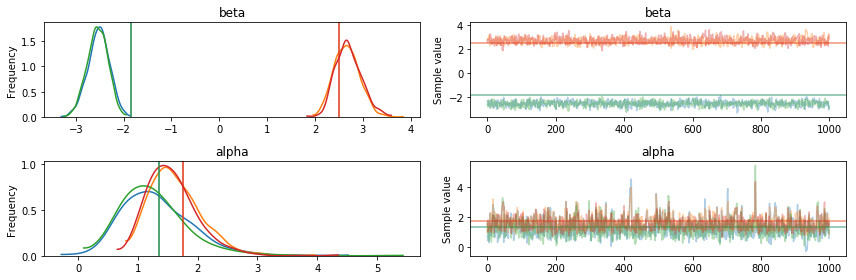

In [5]:
pm.traceplot(trace, lines=dict(alpha=true_alpha, beta=true_beta));

In [6]:
with m:
    z = pm.Bernoulli('z', psi, shape=n)
    ppc = pm.sample_ppc(trace, vars=[z])

100%|██████████| 1000/1000 [00:00<00:00, 3889.49it/s]


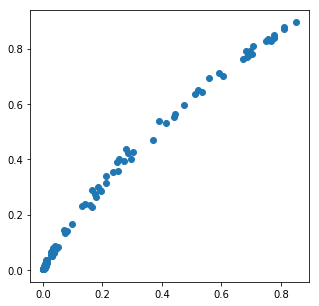

In [7]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(ppc['z'].mean(axis=0), true_psi, 'o');

In [34]:
import theano
import theano.tensor as tt
zero_prob = theano.shared(np.ones(y_r.shape)*1e-100)

In [35]:
with pm.Model() as m2:
    beta = pm.Normal('beta', mu=0, sd=10, shape=(2, 1)) 
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=(2, 1))
    x_b = pm.math.dot(X, beta)
    psi = pm.math.invlogit(x_b).flatten()
    
    w_a = pm.math.dot(W_r, alpha)
    d = pm.math.invlogit(w_a)
    
    # z = pm.Bernoulli('z', psi, shape=n)
    # prob = z[index] * d
    prob = tt.concatenate([zero_prob, d], axis=1)
    w = tt.concatenate([1-psi[index], psi[index]], axis=1)
    comp_dists = pm.Bernoulli.dist(prob)
    obs = pm.Mixture('y', w=w, comp_dists=comp_dists, observed=y_r)
    
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:29<00:00, 133.70draws/s]


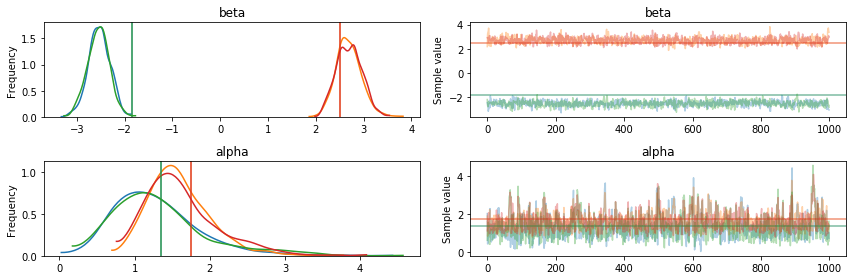

In [36]:
pm.traceplot(trace2, lines=dict(alpha=true_alpha, beta=true_beta));

In [37]:
with m2:
    z = pm.Bernoulli('z', psi, shape=n)
    ppc2 = pm.sample_ppc(trace2, vars=[z])

100%|██████████| 1000/1000 [00:00<00:00, 3877.76it/s]


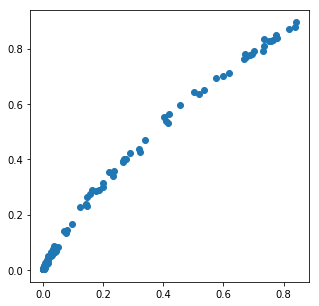

In [38]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(ppc2['z'].mean(axis=0), true_psi, 'o');